# Example 5.4 (Simultaneous confidence intervals as shadows of the confidence ellipse)

In [1]:
import pathlib
import numpy as np
import pandas as pd
from MultivariateFunctionsCh5 import MultivariateFunctionsCh5

In [2]:
def load_data() -> pd.DataFrame:
    """
    Load the microwave radiation data from Example 5.3 and Example 5.4.
    """
    closed_pth = pathlib.Path('..\..\data\Table4.1.xlsx')
    closed_df = pd.read_excel(closed_pth, names=['Oven', 'ClosedRadiation'])

    open_pth = pathlib.Path('..\..\data\Table4.5.xlsx')
    open_df = pd.read_excel(open_pth, names=['Oven', 'OpenRadiation'])

    return closed_df.merge(open_df).set_index('Oven')**(1/4)

In [3]:
radiation_df = load_data()
radiation_df.head(3)

,ClosedRadiation,OpenRadiation
Oven,,
1,0.622333,0.740083
2,0.547723,0.547723
3,0.651356,0.740083


In [4]:
X = radiation_df.to_numpy()
n, p = X.shape
alpha = 0.05

In [5]:
simul_ci = MultivariateFunctionsCh5.simult_conf_int(X, alpha=alpha)
simul_ci

array([[0.51668028, 0.61183474],
       [0.55508174, 0.65088074]])

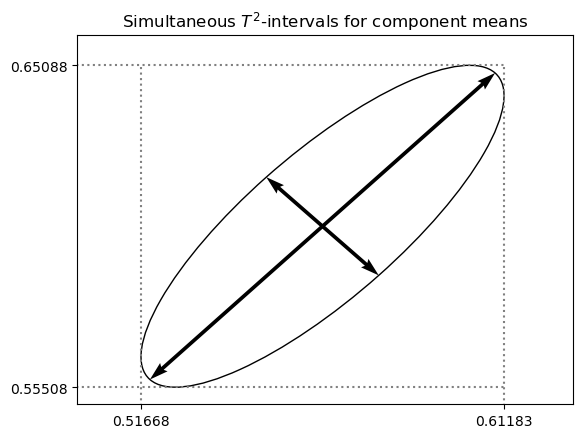

In [6]:
xbar = np.mean(X, axis=0)
my_plot, ax = MultivariateFunctionsCh5.plot_confidence_ellipse(
    X, n, p, alpha=0.05)
ax.set_title('Simultaneous $T^{2}$-intervals for component means')
my_plot.xlim([0.50, 0.63])
my_plot.ylim([0.55, 0.66])

# Draw dashed lines at the simultaneous T^2 values (closed).
ax.plot([simul_ci[0,0], simul_ci[0,0]], [0, simul_ci[1,1]], linestyle=':', color='gray')
ax.plot([simul_ci[0,1], simul_ci[0,1]], [0, simul_ci[1,1]], linestyle=':', color='gray')

# Draw dashed lines at the simultaneous T^2 values (open).
ax.plot([0, simul_ci[0,1]], [simul_ci[1,1], simul_ci[1,1]], linestyle=':', color='gray')
ax.plot([0, simul_ci[0,1]], [simul_ci[1,0], simul_ci[1,0]], linestyle=':', color='gray')

# Label simultaneous CI on the axis.
ax.set_xticks(simul_ci[0,:])
ax.set_yticks(simul_ci[1,:])

my_plot.show()